# FIT 5196 Assessment 4

Date: 30 May 2017 
 
Version: 1

Environment: Python 2.7.13 and Jupyter notebook


### Description
This assessment covers topics from weeks 9 to 11, mainly about **Data Integration** and **Data Reshaping**.  

The availability of data nowadays and the speed at which data is generated is unprecedented. In connection, different data formats have been introduced to satisfy different needs and requirements in storing and presenting data. In order to combine these datasets for further analysis and greater value, proper merging and integration is important. 

Furthermore, data normalisation is also necessary in order to maintain better predictive models by 'scaling' different attributes. Data transformation and normalisation helps data scientists to better see any relationships between variables and allows them to perform some methods that are limited to specific sets of data (e.g. methods where Gaussian variables are expected).

The data used are in the XML and CSV form, but both files pertain to a collection of property sales in **King County, Washington** from **May to July 2014**. Further description of the individual datasets will be shown below. According to the assignment specifications, 430 sales records are found in the XML file while 4,600 records are in the CSV file.

This assessment will illustrate how to parse both XML and CSV files into a Pandas DataFrame, how to create a **mediated (also known as global) schema** to integrate both data frames and reconcile both data sources based from  this schema, and transforming variables using Z-Score Normalization, Min-Max Scaling, and Log Transformation.

### Contents
1. Importing Libraries
2. Reading the Data
    - Reading and Describing the XML File
    - Reading and Describing the CSV File
3. Defining the Mediated Schema
4. Parsing the XML File
    - Converting the XML nodes to Pandas DataFrame
    - Defining Tasks for Schema and Data Integration
    - Parsing Address
        - Extracting different address components
        - Checking Country Values
        - Checking Zip Code Values
        - Checking State Values
        - Creating StateZip Column
        - Checking County Values
        - Checking City Values
        - Checking Street Values
    - Parsing Price
    - Parsing Bedrooms, Bathrooms, Floors
    - Parsing Areas (Living Area, Lot Area, Upper Area, Basement Area)
    - Parsing Waterfront and View
    - Parsing Sold_Date
    - Parsing Build_Year and Renovate Year
    - Renaming and Reordering Columns
5. Parsing the CSV File
    - Defining Tasks for Schema and Data Integration
    - Parsing Price
    - Parsing Date
    - Parsing Street
    - Parsing City
    - Parsing Statezip
    - Parsing Country
    - Parsing Yr_Built & Yr_Renovated
    - Removing Columns
    - Renaming and Reordering Columns
6. Forming the Integrated Data Frame
7. Price Data Reshaping
    - Z-Score Normalisation
    - Min-Max Normalisation
    - Log Transformation
    - Plots and Analysis
8. Summary
9. References
    

In [1]:
!python --version

Python 2.7.13 :: Anaconda 4.3.0 (64-bit)


# 1. Importing Libraries
The following libraries are used:

- **pandas** - for putting the data into the DataFrame and the suceeding DataFrame operations (pandas Developers, 2012)
- **BeautifulSoup** - for reading and parsing the XML File (Richardson, 2012)
- **numpy** - for faster numerical calculations (Numpy Developers, 2017)
- **matplotlib.pyplot** - for graph the data (Matplotlib Development Team, 2017)
- **math** - for performing log transform (Python Software Foundation, 2012)


In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# 2. Reading the Data

This part comprises reading and analysing both XML and CSV files. Both files are parsed into a data frame and its columns analysed to come up with a reconciled mediated schema.

## 2.1 Reading and Describing the XML File
The XML file contains a collection of 430 records which pertain to the sales of properties accross King County, Washington on July 2014.

**BeautifulSoup** was used in order to read and extract the data. (Richardson, 2012) BeautifulSoup provides an easy interface in reading both HTML and XML file using the `find()` and `find_all()` functions. The former is used to find individual tags in a node while the latter is used to get a collection of nodes. To get the values of the tags' attributes, BeautifulSoup methods `has_attrs()` and `attrs[]` are used.  

In [3]:
infile = open("data_s2_ass4.xml", "r")
contents = infile.read()
soup = BeautifulSoup(contents, "lxml")
infile.close()

Check if 430 records are found and show what does a record look like.

In [4]:
records = soup.find_all('record')
print 'Number of records: ' + str(len(soup.find_all('record')))
print ''
print records[0]
print ''
print records[41]
print ''
print records[369]

Number of records: 430

<record>
<date>2014-07-19</date>
<address>10515, 115th Place Northeast, Juanita, Kirkland, King County, Washington, 98033, United States of America</address>
<price>630000</price>
<solddate>2014-07-09</solddate>
<bedrooms>3</bedrooms>
<bathrooms>1.75</bathrooms>
<livingarea unit="sqm">158.8641984</livingarea>
<lotarea unit="sqm">814.48095168</lotarea>
<floors>1.0</floors>
<waterfront></waterfront>
<view></view>
<upperarea unit="sqm">158.8641984</upperarea>
<basementarea></basementarea>
<buildyear>1986</buildyear>
<renovateyear>0</renovateyear>
</record>

<record>
<date>2014-07-15</date>
<address>6824, Phinney Avenue North, Phinney Ridge, Seattle, King County, Washington, 98103, United States of America</address>
<price>569950</price>
<solddate>2014-07-10</solddate>
<bedrooms>4</bedrooms>
<bathrooms>1.0</bathrooms>
<livingarea unit="sqm">105.9094656</livingarea>
<lotarea unit="sqm">551.8440576</lotarea>
<floors>1.0</floors>
<waterfront></waterfront>
<view>2</view

Checking the XML file, a `<record>` has the following child nodes:

1. **date** - The date which the entry was logged.
2. **address** - The complete address of the property.
3. **price** - The price at which the property was sold.
4. **solddate** - The date which the property was sold.
5. **bedrooms** - The number of bedrooms.
6. **bathrooms** - The number of bathrooms.
7. **livingarea** - The area of living space, of which unit is an attribute.
8. **lotarea** - The area of the lot, of which unit is an attribute.
9. **floors** - The number of floors.
10. **waterfront** - Indicates whether a property is in front of a body of water or not.
11. **view** - Indicates whether a property has a view or not. 
12. **upperarea** - The area of the living space over the terrain, of which unit is an attribute.
13. **basementarea** - The area of the living space under the terrain, of which unit is an attribute.
14. **buildyear** - The year the property was built.
15. **renovateyear** - The year the property was renovated.

The following are **numeric variables**:
- *Discrete*: price, bedrooms, bathrooms, floors
- *Continuous*: livingarea, lotarea, upperarea, basementarea
- *Time*: date, solddate, buildyear, renovateyear

The following are **categorical variables**:
- *Ordinal:* waterfront, view
- *Nominal:* address

### 2.1.1 Converting the XML Nodes to Pandas DataFrame

The XML File will then be converted into a DataFrame. But first, check if for every record node there are only single tags of the variables indicated above. I created a method called `check_multiple_tags()` to do this. This method will use BeautifulSoup's `findAll()` method and check if it was able to find more than 1 node per variable.

In [5]:
# Check if there are a list of tags that we should now about before extracting the record.
# Example:
# <parent> 
#       <child> </child>
#       <child> </child>
# </parent>
def check_multiple_tags(tagname):
    nodes = record.findAll(tagname)
    if (len(nodes) > 1):
        print 'multiple ', tagname, ' exist.'
    if (len(nodes) == 0):
        print 'empty ', tagname, ' exist.'

for record in records:
    check_multiple_tags('date')
    check_multiple_tags('address')
    check_multiple_tags('price')
    check_multiple_tags('solddate')
    check_multiple_tags('bedrooms')
    check_multiple_tags('bathrooms')
    check_multiple_tags('livingarea')
    check_multiple_tags('lotarea')
    check_multiple_tags('floors')
    check_multiple_tags('waterfront')
    check_multiple_tags('view')
    check_multiple_tags('upperarea')
    check_multiple_tags('basementarea')
    check_multiple_tags('buildyear')
    check_multiple_tags('renovateyear')

Since the XML File is structured as expected, I now created a function called `extract_record()` to extract values inside the nodes . Again **BeautifulSoup** methods are utilised for this. The function returns a **Pandas Series** (Pandas Developers, 2017) which is structured like a Python tuple but with indices that tags each element.

The final outcome is a collection of Pandas Series that can now be formed into a **Pandas Data Frame** (Pandas Developers, 2014).

In [6]:
recordSeries = []

# Extract the values from the nodes and put it into a Pandas Series.
def extract_record(record):
    date = record.find('date').text
    address = record.find('address').text
    price = record.find('price').text
    soldDate = record.find('solddate').text
    bedrooms = record.find('bedrooms').text
    bathrooms = record.find('bathrooms').text
    livingAreaTag = record.find('livingarea')
    livingArea = livingAreaTag.text
    
    # Extract the living area unit by checking the attribute 'unit'.
    if (livingAreaTag.has_attr('unit')):
        livingAreaUnit = livingAreaTag.attrs['unit'].strip()
    # If the unit does not exist put blank.
    else:
        livingAreaUnit = ''
    
    lotAreaTag = record.find('lotarea')
    lotArea = lotAreaTag.text
    
    # Extract the lot area unit by checking the attribute 'unit'.
    if (lotAreaTag.has_attr('unit')):
        lotAreaUnit = lotAreaTag.attrs['unit'].strip()
    # If the unit does not exist put blank.
    else:
        lotAreaUnit = ''
        
    floors = record.find('floors').text
    waterFront = record.find('waterfront').text
    view = record.find('view').text
    
    upperAreaTag = record.find('upperarea')
    upperArea = upperAreaTag.text
    
    # Extract the upper area unit by checking the attribute 'unit'.
    if (upperAreaTag.has_attr('unit')):
        upperAreaUnit = upperAreaTag.attrs['unit'].strip()
    # If the unit does not exist put blank.
    else:
        upperAreaUnit = ''
    
    basementAreaTag = record.find('basementarea') 
    basementArea = basementAreaTag.text
    
    # Extract the basement area unit by checking the attribute 'unit'.
    if (basementAreaTag.has_attr('unit')):
        basementAreaUnit = basementAreaTag.attrs['unit'].strip()
    # If the unit does not exist put blank.
    else:
        basementAreaUnit = ''
            
    buildYear = record.find('buildyear').text
    renovateYear = record.find('renovateyear').text
    
    # Put the extracted texts into a tuple.
    newTuple = [date, 
                address, 
                price, 
                soldDate, 
                bedrooms, 
                bathrooms, 
                livingArea, 
                livingAreaUnit,
                lotArea,
                lotAreaUnit,
                floors, 
                waterFront, 
                view, 
                upperArea, 
                upperAreaUnit,
                basementArea, 
                basementAreaUnit,
                buildYear, 
                renovateYear]
    
    # Convert the tuple into a Pandas Series.
    # Notice that the units have different indices so we can checkout the values later.
    newSeries = pd.Series(newTuple,
                          index = ['date', 
                                  'address', 
                                  'price', 
                                  'sold_date', 
                                  'bedrooms', 
                                  'bathrooms', 
                                  'living_area',
                                  'living_area_unit',
                                  'lot_area',
                                  'lot_area_unit',
                                  'floors', 
                                  'waterfront', 
                                  'view',
                                  'upper_area', 
                                  'upper_area_unit',
                                  'basement_area', 
                                  'basement_area_unit',
                                  'build_year', 
                                  'renovate_year'])
    
    return newSeries

# Extract the records and put them into a collection of Pandas Series.
recordSeries = [extract_record(record) for record in records]

print(len(recordSeries))

430


Check if the texts were extracted and they are where they're supposed to be.

In [7]:
# Sanity check. Are we able to extract the data properly?
print recordSeries[400]
print ''
print recordSeries[100]

date                                                         2014-07-16
address               Elk Meadows Park, Warner Avenue East, Enumclaw...
price                                                            272000
sold_date                                                    2014-07-15
bedrooms                                                              4
bathrooms                                                           2.0
living_area                                                 173.7286848
living_area_unit                                                    sqm
lot_area                                                   608.60781504
lot_area_unit                                                       sqm
floors                                                              1.0
waterfront                                                             
view                                                                  3
upper_area                                                  173.

In [8]:
# Create a Pandas Data Frame from a list of Series.
xmlData = pd.DataFrame(recordSeries)

In [9]:
# Show the resulting data frame from the XML file.
xmlData.head()

,date,address,price,sold_date,bedrooms,bathrooms,living_area,living_area_unit,lot_area,lot_area_unit,floors,waterfront,view,upper_area,upper_area_unit,basement_area,basement_area_unit,build_year,renovate_year
0,2014-07-19,"10515, 115th Place Northeast, Juanita, Kirklan...",630000,2014-07-09,3,1.75,158.8641984,sqm,814.48095168,sqm,1.0,,,158.8641984,sqm,,,1986,0
1,2014-07-10,"1501, Northwest 90th Street, Ballard, Seattle,...",599950,2014-07-09,3,3.25,170.0125632,sqm,167.59708416,sqm,3.0,,,170.0125632,sqm,,,2014,0
2,2014-07-16,"537, North 70th Street, Phinney Ridge, Seattle...",680000,2014-07-09,3,2.0,165.3674112,sqm,531.4053888,sqm,1.0,,,91.0449792,sqm,74.322432,sqm,1925,0
3,2014-07-13,"12008, 35th Avenue Northeast, Cedar Park, Lake...",335500,2014-07-09,3,1.0,127.2771648,sqm,629.8826112,sqm,2.0,,,127.2771648,sqm,,,1930,0
4,2014-07-18,"11807, Northeast 105th Court, Juanita, Kirklan...",379000,2014-07-09,3,2.5,142.1416512,sqm,270.62655552,sqm,2.0,,,142.1416512,sqm,,,1986,0


### 2.1.2 Initial Checking for Area Units
The continuous variables in the XML file have an attribute called **units**. These attributes were put in a separate column to check if they are all the same (square metres). To do this I used **Pandas'** method called `value_counts()` that  enumerates the unique values in a column. 

If the values are all **sqm** then these columns can be eliminated.

In [10]:
# Check the values of the units of all continuous variables.
print 'Living Area Unit values:'
print xmlData['living_area_unit'].value_counts()
print '\nLot Area Unit values:'
print xmlData['lot_area_unit'].value_counts()
print '\nUpper Area Unit values:'
print xmlData['upper_area_unit'].value_counts()
print '\nBasement Area Unit values:'
print xmlData['basement_area_unit'].value_counts() 

Living Area Unit values:
sqm    430
Name: living_area_unit, dtype: int64

Lot Area Unit values:
sqm    430
Name: lot_area_unit, dtype: int64

Upper Area Unit values:
sqm    430
Name: upper_area_unit, dtype: int64

Basement Area Unit values:
       249
sqm    181
Name: basement_area_unit, dtype: int64


Renamed the columns of *living_area*, *lot_area*, *upper_area* and *basement_area* to **sqm.living_area**, **sqm.lot_area**, **sqm.upper_area**, **sqm.basement_area** since all units are in **sqm**.

In [11]:
# Since all values have 'sqm' as units, just change the column name as sqm.living_area and so on.
xmlData.rename(columns = {
            'living_area': 'sqm.living_area', 
            'lot_area': 'sqm.lot_area', 
            'upper_area': 'sqm.upper_area', 
            'basement_area': 'sqm.basement_area'}, inplace = True)

In [12]:
# Drop the '-units' column.
xmlData.drop('living_area_unit', axis = 1, inplace = True)
xmlData.drop('lot_area_unit', axis = 1, inplace = True)
xmlData.drop('upper_area_unit', axis = 1, inplace = True)
xmlData.drop('basement_area_unit', axis = 1, inplace = True)

The resulting DataFrame generated from the XML file is shown below. 

In [13]:
xmlData.head(5)

,date,address,price,sold_date,bedrooms,bathrooms,sqm.living_area,sqm.lot_area,floors,waterfront,view,sqm.upper_area,sqm.basement_area,build_year,renovate_year
0,2014-07-19,"10515, 115th Place Northeast, Juanita, Kirklan...",630000,2014-07-09,3,1.75,158.8641984,814.48095168,1.0,,,158.8641984,,1986,0
1,2014-07-10,"1501, Northwest 90th Street, Ballard, Seattle,...",599950,2014-07-09,3,3.25,170.0125632,167.59708416,3.0,,,170.0125632,,2014,0
2,2014-07-16,"537, North 70th Street, Phinney Ridge, Seattle...",680000,2014-07-09,3,2.0,165.3674112,531.4053888,1.0,,,91.0449792,74.322432,1925,0
3,2014-07-13,"12008, 35th Avenue Northeast, Cedar Park, Lake...",335500,2014-07-09,3,1.0,127.2771648,629.8826112,2.0,,,127.2771648,,1930,0
4,2014-07-18,"11807, Northeast 105th Court, Juanita, Kirklan...",379000,2014-07-09,3,2.5,142.1416512,270.62655552,2.0,,,142.1416512,,1986,0


In [14]:
xmlData.describe()

,date,address,price,sold_date,bedrooms,bathrooms,sqm.living_area,sqm.lot_area,floors,waterfront,view,sqm.upper_area,sqm.basement_area,build_year,renovate_year
count,430,430,430,430,430,430,430,430,430,430,430,430,430,430,430
unique,18,429,315,8,8,15,248,374,5,2,5,220,105,101,19
top,2014-07-17,"98027; 98006, 158th Place Southeast, Eastgate,...",650000,2014-07-14,3,2.5,133.7803776,464.5152,1.0,,,100.3352832,,1968,0
freq,45,2,6,116,197,105,7,12,222,427,396,8,249,13,404


In [15]:
xmlData.describe(include = ['O'])

,date,address,price,sold_date,bedrooms,bathrooms,sqm.living_area,sqm.lot_area,floors,waterfront,view,sqm.upper_area,sqm.basement_area,build_year,renovate_year
count,430,430,430,430,430,430,430,430,430,430,430,430,430,430,430
unique,18,429,315,8,8,15,248,374,5,2,5,220,105,101,19
top,2014-07-17,"98027; 98006, 158th Place Southeast, Eastgate,...",650000,2014-07-14,3,2.5,133.7803776,464.5152,1.0,,,100.3352832,,1968,0
freq,45,2,6,116,197,105,7,12,222,427,396,8,249,13,404


## 2.2 Reading and Describing the CSV File

The CSV (comma-separated value) file is a collection of 4600 property sales records from the same location (all in Washington, USA), from May to July 2014. 

Parsing the CSV file is easier with the help of **Pandas'** `read_csv()` function. This conveniently converts the CSV file into a Pandas Data Frame, parsing it along the way.

In [16]:
csvData = pd.read_csv('data_s1_ass4.csv')

In [17]:
csvData.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313k,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,20140502T000000,2.384m,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA
2,20140502T000000,342k,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,20140502T000000,420k,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA
4,20140502T000000,550k,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA


Checking the CSV file, the dataset has the following variables:

1. **date** - The date which the property was sold.
2. **price** - The price at which the property was sold.
3. **bedrooms** - The number of bedrooms.
4. **bathrooms** - The number of bathrooms.
5. **sqft_living** - The area of living space, in square feet (sqft).
6. **sqft_lot** - The area of the lot, in sqft.
7. **floors** - The number of floors.
8. **waterfront** - Indicates whether a property is in front of a body of water or not.
9. **view** - Indicates whether a property has a view or not.
10. **condition** - Rates the condition of a property, from 1 to 5.
11. **sqft_above** - The area of the living space over the terrain, in square feet.
12. **sqft_basement** - The area of the living space under the terrain, in square feet.
13. **yr_built** - The year the property was built.
14. **yr_renovated** -  The year the property was renovated.
15. **street** - The street of the property.
16. **city** - The city where the property is in.
17. **statezip** - The state and the zipcode of the property.
18. **country** - The country of the the property.

The following are **numeric variables**:
- *Discrete*: price, bedrooms, bathrooms, floors
- *Continuous*: sqft_living, sqft_lot, sqft_above, sqft_basement
- *Time*: date, yr_built, yr_renovated

The following are **categorical variables**:
- *Ordinal:* waterfront, view, condition
- *Nominal:* street, city, statezip, country

In [18]:
# Check the column's data types.
print csvData.dtypes

date              object
price             object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated     float64
street            object
city              object
statezip          object
country           object
dtype: object


In [19]:
csvData.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,224.000000
mean,3.400870,2.160707,2139.068696,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,311.803261,1970.766739,1996.776786
std,0.908848,0.783959,963.229803,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,463.856471,29.733676,16.348892
min,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,1934.000000
25%,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,1988.000000
50%,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,2001.000000
75%,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,2010.000000
max,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [20]:
csvData.describe(include = ['O'])

,date,price,street,city,statezip,country
count,4600,4600,4600,4600,4600,4600
unique,70,1646,4525,44,77,1
top,20140623T000000,300k,2520 Mulberry Walk NE,Seattle,WA 98103,USA
freq,142,41,4,1573,148,4600


# 3. Defining the Mediated Schema

Based on the local schema of the two datasets, I have devised the following **global or mediated schema** in order to create an **integrated data frame**:

Global Schema Column | Data Type | Description | XML File Concerns | CSV File Concerns
---------------------|-----------|-------------|----------|----------
**date**| datetime|property sold date in *'yyyy-mm-dd'* format|same format, named as *sold_date*|in the format *'YYYYMMDDTHHMMSS'*
**price**|int64|sold price in *US$* without decimals|same format|needs to expand *k*s and *m*s
**bedrooms**|int64|number of bedrooms|same format|same format
**bathrooms**|float64|number of bathrooms|same format|same format
**sqft_living**|int64|area of living space in *sqft*|in *sqm*, named as *living_area*|same format
**sqft_lot**|int64|area of property lot in *sqft*|in *sqm*, named as *lot_area*|same format
**floors**|int64|number of floors (including mezzanine or balcony)|same format|same format
**waterfront**|int64|pertains to if property is in front of a body of water|needs to discretize|same format
**view**|int64|pertains to if property has a view|needs to discretize|same format
**sqft_above**|int64|area of living space above land in *sqft*|in *sqm*, named as *upper_area*|same format
**sqft_basement**|int64|area of living space below land in *sqft*|in *sqm*, named as *basement_area*|same format
**yr_built**|int64|year property was built (*'yyyy'* format)|same format, named as *build_year*|same format
**yr_renovated**|int64|year property was renovated, if any (*'yyyy'* format) otherwise None|same format, named as *renovate_year*, 0 for unrenovated properties|same format
**street**|string|unit # and street of the property, where terms are abbreviated and in title case|needs to be extracted from the address, all abbreviations are expanded|some are not abbreviated
**city**|string|city where the property is in, in title case|needs to be extracted from the address|same format
**statezip**|string|state and zipcode where the property is in *'WA [zipcode]'* format|needs to be extracted from the address, WA as 'Washington'|same format
**country**|string|country where the property is, supplied as *'USA'*|needs to be extracted from the address, USA as 'United States of America'|same format

**Notes:**
1. I have used **square feet** in quantifying **area variables (sqft_living, sqft_lot, sqft_above, sqft_basement)** as the USA's standard unit of measurement is the *English System*.
2. For the XML file, I excluded the variable **date** because it is not included in the CSV file. Ultimately for datasets like these it is more important to know the **sold_date** rather than the date the record was logged. I have also contrasted the two datasets and the sold_date in the XML file is arranged from earliest to latest like the date in the CSV file. 
3. For the CSV file, I excluded the **condition** variable as it is not available in the XML file. I can *impute* their values but this task's objective is to properly *integrate* two different datasets so I will not do it here.
4. I have formatted the global schema's **date** variable into a Python datetime format which makes it more readable.
5. I represented the **ordinal variables (waterfront and view)** as *numeric* since it will be easier to interpret in this format.
6. For the XML file I will abbreviate terms in the **street** like Northeast (NE), Southwest (SW), Street (St), Avenue (Ave) as this is the US standard, and popular property sites in the US like <a href='http://www.redfin.com'>Redfin</a> and <a href='http://www.zillow.com'>Zillow</a> abbreviate terms when displaying the address.
7. For the XML file I have excluded some parts of the address like **community, neighbourhood, and county** as they are not part of the *US postal system mailing format* (BitBoost Systems, 2011) and they are not available in the CSV file.

My approach is to slowly transform both XML and CSV data frames into the mediated schema format then merge them together to create the integrated data frame.

# 4. Parsing the XML File

I will now parse the XML file in order to transform it in accordance with the global schema. To do this I will use a lot of different **Pandas** functions to manipulate the data frame.

Note that a lot of my changes will have a parameter **`inplace = True`** so the changes will already apply to the data frame. This eliminates the need to assign to it everytime a change is made.

## 4.1 Defining Tasks for Schema and Data Integration

Based on the concerns listed in the previous part a lot of things need to be done to transform the XML data into a form acceptable for integration. These include the following:

1. Removing the **date** column and renaming the **sold_date** as **date**.
2. Converting the **sqm.living_area** column into sqft and creating the **sqft_living** column.
3. Converting the **sqm.lot_area** column into sqft and creating the **sqft_lot** column.
4. Converting the **sqm.upper_area** column into sqft and creating the **sqft_above** column.
5. Converting the **sqm.basement_area** column into sqft and creating the **sqft_basement** column.
6. Converting **waterfront** from blanks and 'Yes' to 0s and 1s, respectively.
7. Converting blank **view** into 0.
8. Converting 0 **renovated_year** into blank.
9. Extracting the street, city, state, zipcode, and country from the **address**.
10. Abbreviating the terms in the street, state, and country.
11. Combining the state and zipcode columns.
12. Renaming **build_year** and **renovated_year** as **yr_built** and **yr_renovated**.


In [21]:
# xmlData.to_csv('xmlFile.csv', index = False)

## 4.2 Parsing XML Address

Checking some examples of the address variable,

`1714, South Pearl Street, Rainier Valley, Seattle, King County, Washington, 98108, United States of America`
`4408, Thackeray Place Northeast, Portage Bay, Wallingford, Seattle, King County, Washington, 98105, United States of America`
`44th Avenue South, Lakeland North, King County, Washington, 98001, United States of America`

the following observations can be made:
- The addresses have different lengths when splitted by a comma.
- They have the following components: **unit/property number\***, **street**, **neighbourhood\***, **community\***, **city**, **county**, **state**, **zipcode**, and **country**
- All terms are **not** abbreviated, especially for the terms in street, state and country.
- An address must have a minimum of **5 commas** based from the components above.

<small>\* means the component is optional</small> 


### 4.2.1 Extracting Different Address Components
Extracting address components is done in reverse, mainly because all the components at the end (country, zipcode, state, county and city) have the same location. The remaining components are either optional or part of a property's street.

The following steps are performed:

1. Split the address by the commas
2. Retrieve components in reverse (starting from the last entry):

    - the length - 1 split goes to the country
    - length - 2 split goes to the zip
    - length - 3 split goes to the state
    - length - 4 split goes to the county
    - length - 5 split goes to the city

    - the street may be the first split OR the first 2 splits
    
3. Create different columns for the extracted data

But first, sanity check: do all records really have a minimum of 5 commas?

In [22]:
# Based on the assumption above, check if an address has less than 5 commas
for i in range(len(xmlData)):
    commas = xmlData.loc[i, 'address'].count(',')
    if (commas < 5):
        print 'Index: ' + str(i)
        print xmlData.loc[i, 'address']

Index: 89
290th Avenue Southeast, Hobart, King County, Washington, United States of America


Looks like one was not. And it's missing a **zipcode**, an essential part since it's in the global schema. Try and populate the zip code.

In [23]:
# Checkout index 89. How many commas does it have?
commas = xmlData.loc[89, 'address'].count(',')
print commas

4


Based on <a href='https://en.wikipedia.org/wiki/Hobart,_Washington'>Wikipedia</a>, Hobart has a zipcode of **98025**.

In [24]:
# Supply the zipcode found in Wikipedia.
xmlData.set_value(89, 'address', u'290th Avenue Southeast, Hobart, King County, Washington, 98025, United States of America')
xmlData.loc[89, 'address']

u'290th Avenue Southeast, Hobart, King County, Washington, 98025, United States of America'

Declare the method for extracting components of interest from the address.

In [25]:
# Declare the components of interest.
countries = []
zipcodes = []
states = []
counties = []
cities = []
streets = []

# Extract them from a record's address.
def extract_address(address):
    addrComponents = address.split(',')
    addrLength = len(addrComponents)
    
    # The last part of the address is the country.
    countries.append(addrComponents[-1])
    # The second to the last part is the zipcode.
    zipcodes.append(addrComponents[-2])
    # The third to the last part is the state.
    states.append(addrComponents[-3])
    # The fourth to the last part is the county.
    counties.append(addrComponents[-4])
    # The fifth to the last part is the city.
    cities.append(addrComponents[-5])
    
    # Check how many splits the street have.
    if (addrLength - 5 == 1):
        k = 1
    # The default number of components allocated for the street is 2 
    else:
        k = 2
    
    street = ''
    for i in range(0, k):
        street = street + addrComponents[i]
        
    # Add a space in the streets - this will help in abbreviating some terms later.
    streets.append(street + ' ')

for i in range(0, len(xmlData)):
        extract_address(xmlData.loc[i, 'address'])

# Check if the components were extracted.
print len(countries)
print len(zipcodes)
print len(states)
print len(counties)
print len(cities)
print len(streets)

430
430
430
430
430
430


In [26]:
# Add the new columns street, city, county, state, zipcode and country.
xmlData['street'] = streets
xmlData['city'] = cities
xmlData['county'] = counties
xmlData['state'] = states
xmlData['zipcode'] = zipcodes
xmlData['country'] = countries

# Reorder the columns so that the address and its newly extracted components are placed together. 
xmlData = pd.DataFrame(xmlData[['date', 'sold_date', 'price', 'bedrooms', 'bathrooms', 'sqm.living_area', 'sqm.lot_area', 'floors', 'waterfront', 'view', 'sqm.upper_area', 'sqm.basement_area', 'build_year', 'renovate_year', 'address', 'street', 'city', 'county', 'state', 'zipcode', 'country']])

Now try resolving data-level conflicts if the values are in accordance to the global schema.

### 4.2.2 Checking Country Values 
Check if the country column only has **United States of America** as value. If that is the case then abbreviate it into **USA** as per the global schema specification.

In [27]:
# Check if all countries are United States of America.
xmlData['country'].value_counts()

 United States of America    430
Name: country, dtype: int64

In [28]:
# Abbreviate the country into USA.
xmlData['country'].replace({' United States of America': 'USA'}, inplace = True)

In [29]:
xmlData['country'].value_counts()

USA    430
Name: country, dtype: int64

### 4.2.3 Checking ZipCode Values
Check if all the **zip codes** are valid. A valid WA zipcode is a 5-digit character that starts with **98---**. 

Since the values will be numerous I have decided to put it in a data frame by using **Pandas'** `reset_index()` to set the indices. This will allow me to filter the values based on frequency.

In [30]:
# Check if all the zip codes are valid.
zipcodes = xmlData['zipcode'].value_counts().reset_index()
zipcodes.columns = ['zipcodes', 'count']

# Logic: zipcodes that appear less frequently tend to be erroneous, so check zipcodes used less than 5 times.
zipcodes[zipcodes['count'] < 5]

,zipcodes,count
40,98065,4
41,98107,4
42,98003,4
43,98019,4
44,98168,4
45,98032,4
46,98040,4
47,98178,4
48,98199,4
49,98055,4


Two zipcodes appear to be erroneous, **98027; 98006** and **98011-9478**. Investigate and check if they should be corrected by crossvalidating it with other sources.

In [31]:
# Check which rows have the zipcode '98027; 98006'
xmlData[xmlData['zipcode'] == ' 98027; 98006']

,date,sold_date,price,bedrooms,bathrooms,sqm.living_area,sqm.lot_area,floors,waterfront,view,...,sqm.basement_area,build_year,renovate_year,address,street,city,county,state,zipcode,country
77,2014-07-20,2014-07-10,710000,4,2.5,266.6317248,835.6628448,1.0,,,...,92.90304,1968,0,"98027; 98006, 158th Place Southeast, Eastgate,...",98027; 98006 158th Place Southeast,Bellevue,King County,Washington,98027; 98006,USA
134,2014-07-12,2014-07-11,582000,5,2.5,258.2704512,1145.9589984,1.0,,,...,110.5546176,1968,0,"98027; 98006, 158th Place Southeast, Eastgate,...",98027; 98006 158th Place Southeast,Bellevue,King County,Washington,98027; 98006,USA


Based from <a href = 'https://www.redfin.com/WA/Bellevue/5-158th-Pl-SE-98008/home/426096'>here</a> and <a href = 'https://www.zillow.com/homedetails/4825-158th-Pl-SE-Bellevue-WA-98006/48781398_zpid/'>here</a>, the zipcode for 158th Place Southeast Eastgate is just 98006, so replace the rows accordingly.

Looking at the addresses in <a href= 'https://goo.gl/maps/qxEgJforaYR2'>Google Maps</a>, there's no 98027 158th Pl SE nor 98006 158th Pl SE, so I will just not indicate any street number.

In [32]:
# Replace the zipcodes of rows 77 and 134 with the researched zipcode.
xmlData.set_value(77, 'zipcode', ' 98006')
xmlData.set_value(134, 'zipcode', ' 98006')

# Replace the streets of rows 77 and 134.
xmlData.set_value(77, 'street', u'158th Place Southeast ')
xmlData.set_value(134, 'street', u'158th Place Southeast ')

print xmlData.loc[77, ['street', 'zipcode']]
print xmlData.loc[134, ['street', 'zipcode']]

street     158th Place Southeast 
zipcode                     98006
Name: 77, dtype: object
street     158th Place Southeast 
zipcode                     98006
Name: 134, dtype: object


In [33]:
# Check which rows have the zipcode '98011-9478'
xmlData[xmlData['zipcode'] == ' 98011-9478']

,date,sold_date,price,bedrooms,bathrooms,sqm.living_area,sqm.lot_area,floors,waterfront,view,...,sqm.basement_area,build_year,renovate_year,address,street,city,county,state,zipcode,country
296,2014-07-23,2014-07-14,447000,3,2.5,161.6512896,282.70395072,2.0,,,...,,2012,0,"24 Hour Fitness - Bothell, 126th Avenue Northe...",24 Hour Fitness - Bothell 126th Avenue Northeast,Bothell,King County,Washington,98011-9478,USA


Based on the gym's <a href = 'https://www.24hourfitness.com/Website/Club/00440'>website</a>, the correct zipcode is just 98011 so just replace it accordingly. 

In [34]:
# Replace row 296's zipcode with 98011
xmlData.set_value(296, 'zipcode', ' 98011')
print xmlData.loc[296]

date                                                        2014-07-23
sold_date                                                   2014-07-14
price                                                           447000
bedrooms                                                             3
bathrooms                                                          2.5
sqm.living_area                                            161.6512896
sqm.lot_area                                              282.70395072
floors                                                             2.0
waterfront                                                            
view                                                                  
sqm.upper_area                                             161.6512896
sqm.basement_area                                                     
build_year                                                        2012
renovate_year                                                        0
addres

### 4.2.4 Checking State Values
Check if the state column only has **Washington** as value. If that is the case then abbreviate it into **WA** as per the global schema specification.

In [35]:
# Check if all values in the 'state' column are Washington.
xmlData['state'].value_counts()

# Convert Washington to its abbreviation, 'WA'.
xmlData['state'].replace({' Washington':'WA'}, inplace = True)

### 4.2.5 Creating the StateZip Column
Integrating the state and zipcode column only needs a **lambda function** that joins the values of these columns with space using the `' '.join()` function.

In [36]:
# Combine the state and zipcode columns together to form the statezip column.
# taken from https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-dataframe-in-pandas-python
xmlData['statezip'] = xmlData[['state', 'zipcode']].apply(lambda x: ''.join(x), axis = 1)

# Drop the two columns.
xmlData.drop('state', axis = 1, inplace = True)
xmlData.drop('zipcode', axis = 1, inplace = True)

### 4.2.6 Checking County Values
Check if the county column only has **King County** as value. If that is the case then it is confirmed that all of the properties in both XML and CSV are in King County. I will not need this in the global schema since the city and statezip are enough.

In [37]:
# Are all properties located in King County?
xmlData['county'].value_counts()

 King County    430
Name: county, dtype: int64

In [38]:
# Affirmative. Drop the county column.
xmlData.drop('county', axis = 1, inplace = True)

### 4.2.7 Checking City Values

Check if the city values are valid. Turn the `value_counts()` output into a data frame again to filter the values.

In [39]:
# Check if all cities are valid.
cities = xmlData['city'].value_counts().reset_index()
cities.columns = ['cities', 'count']

# Select all cities that have less than five instances in the Data Frame.
cities[cities['count'] < 5]

,cities,count
18,Maple Valley,4
19,Novelty,4
20,Lakeland South,4
21,Mercer Island,4
22,Duvall,4
23,White Center,4
24,Fairwood,4
25,Cottage Lake,3
26,Enumclaw,3
27,Tanner,3


Based on this <a href = 'http://washington.hometownlocator.com/counties/cities,cfips,033,c,king.cfm'>website</a>, these are valid cities.  All terms are also in title case so the format is fine.

The last remaining step would just be to remove the space in the first character of the cities caused by the split.

In [40]:
# Strip the first character which is a space.
xmlData['city'] = [ct[1:] for ct in xmlData['city']]
print xmlData['city']

0            Kirkland
1             Seattle
2             Seattle
3             Seattle
4            Kirkland
5             Seattle
6             Seattle
7             Seattle
8             Seattle
9             Seattle
10            Seattle
11            Seattle
12            Seattle
13            Seattle
14            Seattle
15            Seattle
16            Seattle
17            Seattle
18            Seattle
19            Seattle
20            Seattle
21            Seattle
22            Seattle
23            Seattle
24           Kirkland
25            Seattle
26            Seattle
27               Kent
28            Seattle
29            Seattle
            ...      
400          Enumclaw
401          Bellevue
402           Seattle
403            Vashon
404         Covington
405           Kenmore
406       Woodinville
407          Kirkland
408           Seattle
409           Novelty
410       Federal Way
411            Auburn
412           Seattle
413           Seattle
414       

### 4.2.8 Checking Street Values
For the street values, the primary task is to **abbreviate** the direction and road descriptors in accordance with the global schema. I added space at the end during extraction so I could avoid abbreviating terms like 'Northshire' or 'Eastgate'. 

To replace the substrings I just utilized **Pandas' `str.replace()`** function, which matches and replaces *substrings*, not the whole string.

In [41]:
# Abbreviate the expanded terms in the street column since it's the industry standard 
# when representing addresses in the United States.

# Directions
xmlData['street'] = xmlData['street'].str.replace(' Northeast ', ' NE ')
xmlData['street'] = xmlData['street'].str.replace(' Northwest ', ' NW ')
xmlData['street'] = xmlData['street'].str.replace(' Southeast ', ' SE ')
xmlData['street'] = xmlData['street'].str.replace(' Southwest ', ' SW ')
xmlData['street'] = xmlData['street'].str.replace(' North ', ' N ')
xmlData['street'] = xmlData['street'].str.replace(' South ', ' S ')
xmlData['street'] = xmlData['street'].str.replace(' East ', ' E ')
xmlData['street'] = xmlData['street'].str.replace(' West ', ' W ')

# Road Descriptions
xmlData['street'] = xmlData['street'].str.replace(' Avenue', ' Ave')
xmlData['street'] = xmlData['street'].str.replace(' Parkway', ' Pkwy')
xmlData['street'] = xmlData['street'].str.replace(' Street', ' St')
xmlData['street'] = xmlData['street'].str.replace(' Place', ' Pl')
xmlData['street'] = xmlData['street'].str.replace(' Court', ' Ct')
xmlData['street'] = xmlData['street'].str.replace(' Road', ' Rd')
xmlData['street'] = xmlData['street'].str.replace(' Lane', ' Ln')
xmlData['street'] = xmlData['street'].str.replace(' Boulevard', ' Blvd')
xmlData['street'] = xmlData['street'].str.replace(' Highway', ' Hwy')
xmlData['street'] = xmlData['street'].str.replace(' Drive', ' Dr')

In [42]:
# Check the value of the street column.
xmlData['street']

0                  10515 115th Pl NE 
1                    1501 NW 90th St 
2                      537 N 70th St 
3                  12008 35th Ave NE 
4                  11807 NE 105th Ct 
5                     924 26th Ave S 
6                       125 30th Ave 
7                 5626 Keystone Pl N 
8                    1714 S Pearl St 
9              10304 Interlake Ave N 
10                  3822 42nd Ave SW 
11                    548 NE 86th St 
12                  4112 38th Ave SW 
13                  9510 28th Ave NW 
14                5641 Keystone Pl N 
15              4408 Thackeray Pl NE 
16                1925 Walnut Ave SW 
17                    2318 N 60th St 
18                   6732 Mars Ave S 
19                  7335 35th Ave SW 
20                   1018 NE 96th St 
21                5428 Kirkwood Pl N 
22                 5148 S Creston St 
23                   3051 36th Ave W 
24                14206 119th Ave NE 
25                     1718 32nd Ave 
26          

Because I have replaced terms in the between spaces, some streets that start with the abbreviated terms and **do not** have a street number must have been missed. To detect these rows I just used **Pandas' regular expression string matcher `str.match()`**. 

The regular expression used is **`^(?:[A-Z]).*$`**, meaning any string that starts with a capital letter.

In [43]:
# Check for streets that start a capital letter.
xmlData[xmlData['street'].str.match('^(?:[A-Z]).*$')][['street','city','address']]

,street,city,address
31,Island Crest Way and SE 58th St SE 58th St,Mercer Island,"Island Crest Way and SE 58th St, Southeast 58t..."
33,Fire Station 34 633,Seattle,"Fire Station 34, 633, 32nd Avenue East, Broadm..."
38,Victory Outreach Church SW 108th St,White Center,"Victory Outreach Church, Southwest 108th Stree..."
49,Southeast 183rd St,Maple Heights-Lake Desire,"Southeast 183rd Street, Maple Heights-Lake Des..."
79,Kirk Park NE Magnolia St,Issaquah,"Kirk Park, Northeast Magnolia Street, Kirk Par..."
91,Saddleback Trail Eastgate,Bellevue,"Saddleback Trail, Eastgate, Bellevue, King Cou..."
104,I S 234th St,Des Moines,"I, South 234th Street, Des Moines, King County..."
162,NE 9th PL,Sammamish,"NE 9th PL, Sammamish, King County, Washington,..."
293,Village Green Park Dr NE,Issaquah,"Village Green, Park Drive Northeast, Issaquah,..."
324,Northeast Bird St,Duvall,"Northeast Bird Street, Duvall, King County, Wa..."


Most of these streets start with a term that should be abbreviated (e.g. rows **49, 324, 349, and 399**). There are also some weird streets in rows **31, 33, 91, 104, and 401**.

Investigating these streets:
- based on <a href='https://goo.gl/maps/X2KcWqQfxNr'>Google Maps</a> row **31**'s street should just be Island Crestway SE 58th St as the name of the property is Island Crestway & SE 58th St and it would be redundant to show the street twice.
- based on <a href='https://goo.gl/maps/FyXHaSf8ijv'>Google Maps</a> row **33**'s street should be 633 32nd Ave E. It was cut off because the street comprises 3 commas and not the usual 2.
- rows **91 and 401** includes **Eastgate** which is not part of the street (it's a name of the community), so it must be removed.
- row **104**'s property name is `I`. I cannot verify this online so it's best I just leave it as it is.

In [44]:
xmlData.loc[104]

date                                                        2014-07-21
sold_date                                                   2014-07-11
price                                                           258000
bedrooms                                                             3
bathrooms                                                          2.0
sqm.living_area                                            156.0771072
sqm.lot_area                                             1856.01693312
floors                                                             1.0
waterfront                                                            
view                                                                  
sqm.upper_area                                              81.7546752
sqm.basement_area                                            74.322432
build_year                                                        1948
renovate_year                                                        0
addres

In [45]:
# Manually replace the substrings for the streets in these rows.
xmlData.set_value(49, 'street', xmlData.loc[49, 'street'].replace('Southeast', 'SE')) 
xmlData.set_value(399, 'street', xmlData.loc[399, 'street'].replace('Southeast', 'SE'))
xmlData.set_value(349, 'street', xmlData.loc[349, 'street'].replace('Southwest', 'SW'))
xmlData.set_value(324, 'street', xmlData.loc[324, 'street'].replace('Northeast', 'NE'))

# Remove Eastgate since it's not part of the street name. 
xmlData.set_value(91, 'street', 'Saddleback Trail ')
xmlData.set_value(401, 'street', 'NE 8th St ')

# Fix other street names. The spaces at the end will be stripped later.
xmlData.set_value(31, 'street', 'Island Crest Way & SE 58th St ')
xmlData.set_value(162, 'street', 'NE 9th Pl ')
xmlData.set_value(33, 'street', 'Fire Station 34 633 32nd Ave E ')

# Check the values.
print xmlData.loc[49, 'street']
print xmlData.loc[91, 'street']
print xmlData.loc[162, 'street']
print xmlData.loc[324, 'street']
print xmlData.loc[349, 'street']
print xmlData.loc[399, 'street']
print xmlData.loc[324, 'street']
print xmlData.loc[401, 'street']

SE 183rd St 
Saddleback Trail 
NE 9th Pl 
NE Bird St 
SW 270th St 
SE 10th St 
NE Bird St 
NE 8th St 


Since a street name usually ends with either the direction or a road description, I tried to find out any rows that doesn't end with either.

In [46]:
# Check for strings that doesn't end in any abbreviations
xmlData[xmlData['street'].str.match('.*[^St|Ave|S|N|E|W|NE|SE|NW|SW|Pl|Ct|Dr|Ln|Blvd] $')]['street']

86        12412 NE 80th Way 
233    16531 SE Newport Way 
256        3798 Hampton Way 
262       4372 W Mercer Way 
395      21629 SE 299th Way 
Name: street, dtype: object

All of these terms end in **Way**. The term **'Way'** is not being abbreviated when displaying US addresses. This term was also not abbreviated in the CSV File.

Now that I'm done processing the street column I could just remove the space I added earlier.

I can also drop the address column now.

In [47]:
# Remove the space added at the end of the string
xmlData['street'] = [street[:-1] for street in xmlData['street']]

In [48]:
# Drop the address column.
xmlData.drop('address', axis = 1, inplace = True)

## 4.3 Parsing XML Price
Since the XML prices are already in the global schema format, just convert it to numeric to make sure all prices are int int64 format using **Pandas' `to_numeric()`** method. This method converts the column into a numeric data type, while specifying `errors = 'raise'` to throw and raise any exceptions encountered during parsing.

In [49]:
# Check if all the price values are numeric.
xmlData['price'] = pd.to_numeric(xmlData['price'], errors = 'raise')

## 4.4 Parsing XML Bedrooms, Bathrooms, & Floors
The same goes for the discrete variables bedrooms, bathrooms, and floors. Use the same method to ensure these columns are in the expected format (int64 and float64).

In [50]:
# Check if all bedrooms, bathrooms, and floors are numeric.
xmlData['bedrooms'] = pd.to_numeric(xmlData['bedrooms'], errors = 'raise')
xmlData['bathrooms'] = pd.to_numeric(xmlData['bathrooms'], errors = 'raise')
xmlData['floors'] = pd.to_numeric(xmlData['floors'], errors = 'raise')

## 4.5 Parsing XML Areas (Living Area, Lot Area, Upper Area, Basement Area)
Because the United States use the **English System of Measurement**, it is better to convert the variables in sqm to sqft.

To convert the sqm.living_area, sqm.lot_area, sqm.upper_area and sqm.basement_area to sqft, I did **scalar multiplication**. According to various internet resources (<a href = 'http://www.metric-conversions.org/area/square-meters-to-square-feet.htm'>1</a>, <a href='http://www.convertunits.com/from/sq+m/to/sq+ft'>2</a>, <a href='https://www.google.com.au/search?q=1+sqm+to+sqft&oq=1+sqm&aqs=chrome.1.69i57j0l5.6956j0j7&sourceid=chrome&ie=UTF-8'>3</a>), 1 sqm is equal to **10.7639104167 sqft**. 

Drop the old columns after performing scalar multiplication.

In [51]:
# Check if the living_area, lot_area, upper_area, and basement_area are numeric.
xmlData['sqm.living_area'] = pd.to_numeric(xmlData['sqm.living_area'], errors = 'raise')
xmlData['sqm.lot_area'] = pd.to_numeric(xmlData['sqm.lot_area'], errors = 'raise')
xmlData['sqm.upper_area'] = pd.to_numeric(xmlData['sqm.upper_area'], errors = 'raise')
xmlData['sqm.basement_area'] = pd.to_numeric(xmlData['sqm.basement_area'], errors = 'raise')

In [52]:
# As per US standard, need to convert these areas to sqft.
# Create new columns made up of converted values of the areas.
xmlData['sqft.living_area'] = xmlData['sqm.living_area'] * 10.7639104167
xmlData['sqft.lot_area'] = xmlData['sqm.lot_area'] * 10.7639104167
xmlData['sqft.upper_area'] = xmlData['sqm.upper_area'] * 10.7639104167
xmlData['sqft.basement_area'] = xmlData['sqm.basement_area'] * 10.7639104167

# Fill NaNs with 0 for basement area (since it's the only column in the set with NaNs).
xmlData['sqft.basement_area'].fillna(0, inplace=True)

# Remove decimal points.
xmlData['sqft.living_area'] = xmlData['sqft.living_area'].round().astype(int)
xmlData['sqft.lot_area'] = xmlData['sqft.lot_area'].round().astype(int)
xmlData['sqft.upper_area'] = xmlData['sqft.upper_area'].round().astype(int)
xmlData['sqft.basement_area'] = xmlData['sqft.basement_area'].round().astype(int)

# Drop old columns.
xmlData.drop('sqm.living_area', axis = 1, inplace = True)
xmlData.drop('sqm.lot_area', axis = 1, inplace = True)
xmlData.drop('sqm.upper_area', axis = 1, inplace = True)
xmlData.drop('sqm.basement_area', axis = 1, inplace = True)

## 4.6 Parsing XML Waterfront  & View
Convert these categorical variables into numbers using **Pandas' `replace()`** function, which just replaces the values using a specified mapping in a dictionary-like format. 

For waterfront replace blanks with 0 and 'Yes' with 1. For view, since other values are already numeric (1, 2, 3, and 4) just convert blank to 0.

To ensure these columns are numeric, use **Pandas' `to_numeric()`** again.

In [53]:
# Replace watefront with binary values 0 and 1.
xmlData['waterfront'].replace({'':'0', 'Yes':'1'}, inplace = True)
# Replace view with values 0, 1, 2, 3, and 4.
xmlData['view'].replace({'':'0'}, inplace = True)

# Ensure the columns are all in numeric.
xmlData['waterfront'] = pd.to_numeric(xmlData['waterfront'], errors = 'raise')
xmlData['view'] = pd.to_numeric(xmlData['view'], errors = 'raise')

## 4.7 Parsing XML Sold_Date
I just converted the sold_date column into the Python Datetime format using **Pandas' `to_datetime()`** to make sure all the dates are valid. This method converts the column into a datetime data type, while specifying `errors = 'raise'` to throw and raise any exceptions encountered during parsing.

In [54]:
# Convert sold_date to datetime.
xmlData['sold_date'] = pd.to_datetime(xmlData['sold_date'], format = "%Y-%m-%d", errors = 'raise')

Since I will not be using the date column I have decided just to drop it.

In [55]:
# Drop the date column.
xmlData.drop('date', axis = 1, inplace = True)

## 4.8 Parsing XML Build_Year & Renovate_Year
For build_year and renovate_year, perform two tasks:
- ensure both columns have valid dates by converting to datetime then converting it back to string  in 'yyyy' format 
- ensure rows with no renovate_year are `blank` in accordance with the global schema

In [56]:
# Convert the years to datetime.
xmlData['build_year'] = pd.to_datetime(xmlData['build_year'], format = '%Y', errors = 'raise')

# Replace 0 years with '' to ensure they will be NaT when converted to datetime.
xmlData['renovate_year'].replace({'0':''}, inplace = True)

# Convert renovate years to datetime and let the ''s be NaTs.
xmlData['renovate_year'] = pd.to_datetime(xmlData['renovate_year'], format = '%Y', errors = 'coerce')

# convert the yr_built into string %Y format
xmlData['build_year'] = [d.strftime('%Y') if not pd.isnull(d) else '' for d in xmlData['build_year']]

# convert the yr_renovated into string %Y, otherwise if there's no value set as empty
xmlData['renovate_year'] = [d.strftime('%Y') if not pd.isnull(d) else '' for d in xmlData['renovate_year']]

In [57]:
xmlData['build_year'].value_counts()

1968    13
2004    12
2006    12
1996    11
1959    10
1962     9
2005     9
2007     9
1992     9
2008     9
1969     9
2014     9
1966     8
1978     7
1944     7
1963     7
1998     7
1952     7
1977     6
1926     6
1983     6
1986     6
1990     6
1989     6
1967     6
1975     6
1956     5
1960     5
2013     5
1950     5
        ..
1982     2
1985     2
1987     2
1970     2
1907     2
1906     2
1916     2
1946     2
1920     2
1927     2
1991     2
1993     2
1949     2
1905     2
1961     2
2010     1
1973     1
1934     1
1921     1
1971     1
1945     1
1957     1
1901     1
1900     1
1903     1
1999     1
1904     1
1997     1
1918     1
1931     1
Name: build_year, dtype: int64

In [58]:
xmlData['renovate_year'].value_counts()

        404
2014      3
2004      2
2007      2
1991      2
1987      2
2002      2
2011      2
1997      1
1986      1
1993      1
1994      1
1983      1
1996      1
1965      1
2000      1
2006      1
2009      1
1978      1
Name: renovate_year, dtype: int64

## 4.9 Renaming and Reordering Columns
To rename the columns use **Pandas' `rename()`** function which easily maps the old column name into the new column name.

Then, generate a new data frame consisting of the re-ordered columns.

In [59]:
# Rename the columns.
xmlData.rename(columns = {
            'sold_date': 'date',
            'sqft.living_area': 'sqft_living', 
            'sqft.lot_area': 'sqft_lot', 
            'sqft.upper_area': 'sqft_above', 
            'sqft.basement_area': 'sqft_basement',
            'build_year': 'yr_built',
            'renovate_year': 'yr_renovated'}, inplace = True)

# Reorder the Data Frame.
xmlData = pd.DataFrame(xmlData[['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country']])

In [60]:
xmlData.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-07-09,630000,3,1.75,1710,8767,1.0,0,0,1710,0,1986,,10515 115th Pl NE,Kirkland,WA 98033,USA
1,2014-07-09,599950,3,3.25,1830,1804,3.0,0,0,1830,0,2014,,1501 NW 90th St,Seattle,WA 98117,USA
2,2014-07-09,680000,3,2.00,1780,5720,1.0,0,0,980,800,1925,,537 N 70th St,Seattle,WA 98103,USA
3,2014-07-09,335500,3,1.00,1370,6780,2.0,0,0,1370,0,1930,,12008 35th Ave NE,Seattle,WA 98125,USA
4,2014-07-09,379000,3,2.50,1530,2913,2.0,0,0,1530,0,1986,,11807 NE 105th Ct,Kirkland,WA 98033,USA


In [61]:
xmlData.to_csv('xmlFile3.csv', index = False)

# 5. Parsing the CSV File
 
Now that the XML Data has been converted to the global schema, time to do the same for the CSV data. The CSV data is almost identical to the global schema already but with some slight changes. Like the XML dataset, I will still use common **Pandas functions** to manipulate the data frame, with a lot of my changes having a parameter **`inplace = True`** so the changes will already apply to the data frame, eliminating the need to assign to it everytime a change is made.

The changes that needs to be implemented in the CSV data frame are specified below.

## 5.1 Defining Tasks for Schema and Data Integration

The tasks needed to transform the CSV dataset into the global schema are the following:

1. Convert the **price** column into int64 amounts by removing the 'k' and 'm' suffixes.
2. Parse the **date** column into the Python Datetime format for it to be more readable.
3. Check if the **street** column has un-abbreviated terms and abbreviate them as needed.
4. Ensure **yr_built** & **yr_renovated** are in `yyyy` format.


## 5.2 Parsing CSV Price

To convert the price into int64 amounts I created a function called `convert_price()` that checks for the suffix of the prices and multiplies the correct factor accordingly. 

If the suffix is 'k' (meaning **kilo**), then it should be multiplied by **1,000.**
<br/>If the suffix is 'm' (meaning **mega** -- but in actuality it should be 'M' and not 'm', for an amount \* * .000 000 1* does not make sense), then it should be multiplied by **1,000,000**.

To ensure that the amounts have no decimal places, use the `round()` function that rounds the amount to the nearest whole number before converting them to `int`.

In [62]:
# Create a method that converts the price
def convert_price(price):
    # Check the last character of the price.
    # If the price ends in 'k', multiply it by 1,000.
    if price[-1] == 'k':
        amount = float(price[:-1]) * 1000
    # If the price ends in 'm', multiply it by 1,000,000.
    elif price[-1] == 'm':
        amount = float(price[:-1]) * 1000000
    else:
        amount = float(price)
    return int(round(amount))

# Convert the prices into a numeric amount.
converted_prices = [convert_price(price) for price in csvData['price']]
csvData['price'] = converted_prices

In [63]:
csvData.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,20140502T000000,313000,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,20140502T000000,2384000,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA
2,20140502T000000,342000,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,20140502T000000,420000,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA
4,20140502T000000,550000,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA


## 5.3 Parsing CSV Date
Use **Pandas' `to_datetime()`** function again to parse the CSV date column into Python datetime. The format of the date should be indicated as `%Y%m%dT%H%M%S`. 

In [64]:
# Parse the date column as Python Date.
csvData['date'] = pd.to_datetime(csvData['date'], format = "%Y%m%dT%H%M%S", errors = 'raise')

In [65]:
# Check the current state of the CSV data.
csvData.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000,3,1.50,1340,7912,1.5,0,0,3,1340,0,1955,NaN,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000,5,2.50,3650,9050,2.0,0,4,5,3370,280,1921,NaN,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000,3,2.00,1930,11947,1.0,0,0,4,1930,0,1966,NaN,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02,420000,3,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,NaN,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02,550000,4,2.50,1940,10500,1.0,0,0,4,1140,800,1976,NaN,9105 170th Ave NE,Redmond,WA 98052,USA


## 5.4 Parsing CSV Street

Most of the values in the CSV street column are as expected--abbreviated and only contains the street number and the street name. However, to make sure that this holds through all values, check the column for any terms that are **not** abbreviated. Use the `str.match()` function that detects any string that would match the regular expression passed as a parameter.

The regular expression used is `.*<term>.*` which just checks if the term is in any substrings in the column.


In [66]:
# Check if there are any 'North/Northeast/Northwest' terms in street.
csvData[csvData['street'].str.match('.*North.*')]['street']

510      17050 14th Avenue Northeast
981           2632 NW North Beach Dr
1445      7550 14th Avenue Northeast
1848    10629 161st Avenue Northeast
2497      8044 14th Avenue Northeast
3450     15812 14th Avenue Northeast
Name: street, dtype: object

Looks like I caught something. These terms should be abbreviated into NE, and the term **Avenue** should be abbreviated as Ave.

In [67]:
# Abbreviate 'Northeast' to 'NE'.
csvData['street'] = csvData['street'].str.replace(' Northeast', ' NE')
csvData[csvData['street'].str.match('.*North.*')]['street']

981    2632 NW North Beach Dr
Name: street, dtype: object

I will leave **North Beach Dr** as it is because it looks like a valid name of an actual place.

In [68]:
# Check if there are any 'South/Southeast/Southwest' terms in street.
csvData[csvData['street'].str.match('.*South.*')]['street']

26                27736 23rd Avenue South
583     22442-22446 Southeast 281st Court
996         29801-29829 23rd Avenue South
3829               11819 1st Avenue South
4172               17820 1st Avenue South
Name: street, dtype: object

In [69]:
# Abbreviate 'Southeast' and 'South' to 'SE' and 'S' respectively.
csvData['street'] = csvData['street'].str.replace(' Southeast', ' SE')
csvData['street'] = csvData['street'].str.replace(' South', ' S')

In [70]:
csvData[csvData['street'].str.match('.*West.*')]['street']

389      645 West Lake Sammamish Pkwy NE
1906               16633 Westside Hwy SW
2085                 2550 Westmont Way W
2168    2244 West Lake Sammamish Pkwy NE
3361    2860 West Lake Sammamish Pkwy NE
4389                  2425 Westview Dr W
Name: street, dtype: object

In [71]:
# Check if there are any 'East' terms in street.
csvData[csvData['street'].str.match('.*East.*')]['street']

376            5933 S Eastwood Dr
434     East Lake Sammamish Trail
2146          2027 Eastlake Ave E
3106    Eastridge Drive Promenade
Name: street, dtype: object

Since **Eastwood, East Lake Sammamish, Eastlake, and Eastridge** looks like proper place names I will just leave it as it is.

In [72]:
# Check if there are any 'Avenue' terms in street.
csvData[csvData['street'].str.match('.*Avenue.*')]['street']

26            27736 23rd Avenue S
510          17050 14th Avenue NE
996     29801-29829 23rd Avenue S
1445          7550 14th Avenue NE
1848        10629 161st Avenue NE
2497          8044 14th Avenue NE
3450         15812 14th Avenue NE
3829           11819 1st Avenue S
4172           17820 1st Avenue S
Name: street, dtype: object

In [73]:
# Check if there are any 'Drive' terms in street.
csvData[csvData['street'].str.match('.*Drive.*')]['street']

3106    Eastridge Drive Promenade
Name: street, dtype: object

In [74]:
# Check if there are any 'Court' terms in street.
csvData[csvData['street'].str.match('.*Court.*')]['street']

583    22442-22446 SE 281st Court
Name: street, dtype: object

In [75]:
# Abbreviate these terms.
csvData['street'] = csvData['street'].str.replace(' Avenue', ' Ave')
csvData['street'] = csvData['street'].str.replace(' Court', ' Ct')
csvData['street'] = csvData['street'].str.replace(' Drive', ' Dr')

## 5.5 Parsing CSV City
Verify if all cities are in title case and valid.

In [76]:
# Check if all cities are valid.
cities = csvData['city'].value_counts().reset_index()
cities.columns = ['cities', 'count']

# Select all cities that have less than five instances in the Data Frame.
cities[cities['count'] < 5]

,cities,count
37,Yarrow Point,4
38,Skykomish,3
39,Milton,2
40,Preston,2
41,Beaux Arts Village,1
42,Inglewood-Finn Hill,1
43,Snoqualmie Pass,1


All these values look valid.

## 5.6 Parsing CSV Statezip
Verify if statezip values are valid and in the correct format.

In [77]:
# Check if all statezips are valid.
statezips = csvData['statezip'].value_counts().reset_index()
statezips.columns = ['statezip', 'count']

# Select all statezips that have less than five instances in the Data Frame.
statezips[statezips['count'] < 5]

,statezip,count
73,WA 98288,3
74,WA 98354,2
75,WA 98050,2
76,WA 98068,1


## 5.7 Parsing CSV Country

Check the Country column--are they all USA?

In [78]:
csvData['country'].value_counts()

USA    4600
Name: country, dtype: int64

## 5.8 Remove CSV Condition column
As specified in the global schema I would be dropping the Condition column as the other data source does not have this.

In [79]:
# Remove columns that are not needed - condition.
csvData.drop('condition', axis = 1, inplace = True)

## 5.9 Parsing CSV Yr_Built & Yr_Renovated
Ensure that the Yr_Built and Yr_Renovated columns are in `yyyy` format. To do this I followed what I have done with the XML Data's Build_Year and Renovate_Year columns. Convert `to_datetime()` first then convert to string in `yyyy` using `strftime()`.

In [80]:
# Convert the years to datetime.
csvData['yr_built'] = pd.to_datetime(csvData['yr_built'], format = '%Y', errors = 'raise')

# Convert renovate years to datetime and let the 0s be NaTs.
csvData['yr_renovated'] = pd.to_datetime(csvData['yr_renovated'], format = '%Y.0', errors = 'coerce')

# convert the yr_built into string %Y format
csvData['yr_built'] = [d.strftime('%Y') if not pd.isnull(d) else '' for d in csvData['yr_built']]

# convert the yr_renovated into string %Y, otherwise if there's no value set as empty
csvData['yr_renovated'] = [d.strftime('%Y') if not pd.isnull(d) else '' for d in csvData['yr_renovated']]

In [81]:
csvData['yr_built'].value_counts()

2006    111
2005    104
2007     93
2004     92
1978     90
2008     89
2003     89
1967     82
1977     80
2014     78
1968     77
1987     74
1989     72
1990     71
1959     69
2001     68
1962     66
1954     63
1979     60
1947     59
1948     58
1983     57
1976     57
2013     56
1926     55
1960     55
1988     55
1998     55
1942     54
1991     53
       ... 
1909     22
1939     21
1921     20
1937     20
1908     19
1905     19
1930     19
1922     18
1920     18
1923     18
1971     16
1929     16
1931     16
1911     16
1916     16
1907     12
1917     11
1938     11
1914     10
1902     10
1903     10
1901      9
1913      9
1932      9
1904      9
1915      6
1935      6
1933      5
1934      4
1936      3
Name: yr_built, dtype: int64

In [82]:
csvData['yr_renovated'].value_counts()

        4376
2013      23
2014      22
2003      12
2005      10
2000      10
1988       7
2002       7
2009       7
2007       7
2001       6
1998       6
2010       6
1990       6
1983       5
2006       5
1992       5
1994       4
1986       4
1984       4
1985       4
1982       4
1993       4
2011       4
1997       3
1999       3
2004       3
1989       3
1979       2
1955       2
1958       2
2012       2
1969       2
1968       2
1945       2
1980       2
1996       2
1970       2
2008       2
1995       2
1956       2
1971       1
1972       1
1948       1
1954       1
1978       1
1953       1
1934       1
1987       1
1981       1
1991       1
1975       1
1977       1
1960       1
1974       1
Name: yr_renovated, dtype: int64

In [83]:
csvData.head(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02,313000,3,1.50,1340,7912,1.5,0,0,1340,0,1955,,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02,2384000,5,2.50,3650,9050,2.0,0,4,3370,280,1921,,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02,342000,3,2.00,1930,11947,1.0,0,0,1930,0,1966,,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02,420000,3,2.25,2000,8030,1.0,0,0,1000,1000,1963,,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02,550000,4,2.50,1940,10500,1.0,0,0,1140,800,1976,,9105 170th Ave NE,Redmond,WA 98052,USA


# 6.  Forming the Integrated Data Frame
Now that the two data frames have the same columns with matching data types, merge them into a single data frame.

Since both data frames have the same column names, using **Pandas' `merge()`** function (Pandas Developers, 2012) will make integration straightforward. This function will take the two data frames and perform an SQL-like join with the join type specified in the `how` parameter and the pivot columns specified on the `on` parameter. I did an **outer join** because I want to have the **union** of the two datasets, while I specified all the columns in the `on` parameter as the two datasets already have the same column names.

The merge function also has an `indicator` parameter. This checks for the existence of a row in both datasets: **both** can be seen in the **True** column if it can be found in both datasets while **left_only** and **right_only** if it is found in the left Data Frame or right Data Frame respectively. 

I don't have to worry about duplicates since they are already eliminated if an outer join is performed.

In [84]:
# Check the data types. Are the two DataFrame's data types compatible?
print xmlData.dtypes
print ''
print csvData.dtypes

date             datetime64[ns]
price                     int64
bedrooms                  int64
bathrooms               float64
sqft_living               int32
sqft_lot                  int32
floors                  float64
waterfront                int64
view                      int64
sqft_above                int32
sqft_basement             int32
yr_built                 object
yr_renovated             object
street                   object
city                     object
statezip                 object
country                  object
dtype: object

date             datetime64[ns]
price                     int64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
sqft_above                int64
sqft_basement             int64
yr_built                 object
yr_renovated             object
street                   

Since they are compatible, perform the merge.

In [85]:
# Merge the Data Frames on the common columns.
integratedData = pd.merge(xmlData, csvData, how = 'outer', indicator = 'True', on = [u'date', u'price', u'bedrooms', u'bathrooms', u'floors', u'waterfront',
       u'view', u'yr_built', u'yr_renovated', u'sqft_above', u'sqft_basement',
       u'sqft_living', u'sqft_lot', u'street', u'city', u'statezip',
       u'country'])

In [86]:
integratedData.head(10)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,True
0,2014-07-09,630000,3,1.75,1710,8767,1.0,0,0,1710,0,1986,,10515 115th Pl NE,Kirkland,WA 98033,USA,both
1,2014-07-09,599950,3,3.25,1830,1804,3.0,0,0,1830,0,2014,,1501 NW 90th St,Seattle,WA 98117,USA,both
2,2014-07-09,680000,3,2.00,1780,5720,1.0,0,0,980,800,1925,,537 N 70th St,Seattle,WA 98103,USA,both
3,2014-07-09,335500,3,1.00,1370,6780,2.0,0,0,1370,0,1930,,12008 35th Ave NE,Seattle,WA 98125,USA,both
4,2014-07-09,379000,3,2.50,1530,2913,2.0,0,0,1530,0,1986,,11807 NE 105th Ct,Kirkland,WA 98033,USA,both
5,2014-07-09,321500,1,1.00,730,1942,1.0,0,0,730,0,2008,,924 26th Ave S,Seattle,WA 98144,USA,both
6,2014-07-09,599000,7,2.50,2580,5750,1.0,0,0,1880,700,1901,,125 30th Ave,Seattle,WA 98122,USA,both
7,2014-07-09,759000,4,1.75,2100,4750,1.0,0,0,1340,760,1975,,5626 Keystone Pl N,Seattle,WA 98103,USA,both
8,2014-07-09,300000,4,1.75,1820,5015,1.0,0,0,1190,630,1926,,1714 S Pearl St,Seattle,WA 98108,USA,both
9,2014-07-09,359000,3,1.50,1550,4980,1.0,0,0,1080,470,1978,,10304 Interlake Ave N,Seattle,WA 98133,USA,both


Checking out the distribution of the integratedData, looks like there were 30 duplicated records from both sources. The resulting dataset has **5000 records**, with the distribution shown below.

In [87]:
print 'Total number of integrated records: ' + str(len(integratedData))
print 'Total number of records existing in both XML and CSV: ' + str(len(integratedData[integratedData['True'] == 'both']))
print 'Total number of unique records from XML: ' + str(len(integratedData[integratedData['True'] == 'left_only']))
print 'Total number of unique records from CSV: ' + str(len(integratedData[integratedData['True'] == 'right_only']))

Total number of integrated records: 5000
Total number of records existing in both XML and CSV: 30
Total number of unique records from XML: 400
Total number of unique records from CSV: 4570


**Reformat the data into a more readable format.** Sort the data frame by the latest sold date and then strip the True column before saving the data frame into a CSV file.

In [88]:
# Sort the dataset by the latest sold date.
integratedData.sort_values(by = 'date', ascending = 0, inplace = True)

# Reset the indices of the sorted Data Frame.
integratedData.reset_index(inplace = True)

# Drop the index column generated by reset_index().
integratedData.drop('index', axis = 1, inplace = True)
integratedData.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country,True
0,2014-07-16,480000,3,2.50,1940,10035,2.0,0,0,1940,0,1994,,12505 NE 160th Pl,Woodinville,WA 98072,USA,left_only
1,2014-07-16,645000,3,1.75,2340,6750,1.5,0,0,1620,720,1914,,9052 Burke Ave N,Seattle,WA 98103,USA,left_only
2,2014-07-16,785000,4,2.50,2290,13416,2.0,0,0,2290,0,1981,,NE 8th St,Bellevue,WA 98008,USA,left_only
3,2014-07-16,470000,3,1.00,1010,5000,1.0,0,0,1010,0,1952,,2823 NW 64th St,Seattle,WA 98107,USA,left_only
4,2014-07-16,517534,2,1.00,833,143947,1.0,0,0,833,0,2006,,115th Ave SW,Vashon,WA 98070,USA,left_only


In [89]:
integratedData.to_csv('merged.csv', index = False)

# Drop the 'True' column.
integratedData.drop('True', axis = 1, inplace = True)
integratedData.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-07-16,480000,3,2.50,1940,10035,2.0,0,0,1940,0,1994,,12505 NE 160th Pl,Woodinville,WA 98072,USA
1,2014-07-16,645000,3,1.75,2340,6750,1.5,0,0,1620,720,1914,,9052 Burke Ave N,Seattle,WA 98103,USA
2,2014-07-16,785000,4,2.50,2290,13416,2.0,0,0,2290,0,1981,,NE 8th St,Bellevue,WA 98008,USA
3,2014-07-16,470000,3,1.00,1010,5000,1.0,0,0,1010,0,1952,,2823 NW 64th St,Seattle,WA 98107,USA
4,2014-07-16,517534,2,1.00,833,143947,1.0,0,0,833,0,2006,,115th Ave SW,Vashon,WA 98070,USA


In [90]:
integratedData.to_csv('Jose_2866049_Ass4_data.csv', index = False)

# 7. Data Reshaping

This part will reshape the Price column of the Integrated Dataset in three forms:
- **Z Score Normalization** - which gets the Z Score by normalizing a dataset by its mean and standard deviation
- **Min Max Scaling** - which scales the dataset by its minimum and maximum value
- **Log Transfromation** - which transforms the dataset by getting the logarithmic function of each item in the dataset

**NumPy functions** (NumPy Developers, 2017) are used to get some statistics and convert the price column into a **NumPy array**. NumPy makes it faster to compute for some statistical functions like mean() and std() when the dataset is in a NumPy array.

Analysis of the resulting plots of the data transforms are then made.

## 7.1 Z-Score Normalization
**Z-Score Normalization** is used to transform all means of the variables to 0 and all standard deviation to 1. (Gattiker, 2013) This helps remove distortions that stem from the variables having different means and standard deviations without having to remove the outliers. 

Given a dataset x, the standard equation for Z-Score Normalization is:

**<center>z<sub>i</sub> = (x<sub>i</sub> - mean(x))/(std(x))</center>**

Values above the mean will have positive values, while values below the mean will have negative values. The overall shape of a distribution will not change after normalization. 

This is preferred when comparing two variables with different units and many Machine Learning algorithms also require normalization. (Raschka, 2014)


In [91]:
x = integratedData['price']
numpyPrice = np.asarray(x)  

# Z-score normalization
priceZScoreNormalization = (numpyPrice - numpyPrice.mean()) / numpyPrice.std()
priceZScoreNormalization

array([-0.20655786,  0.23338516,  0.60667014, ..., -0.79314855,
       -0.66383196, -0.31321071])

## 7.2 Min-Max Scaling
**Min-Max Scaling** is a method used to scale a variable into another range with a specified `min` and `max`. This is used if a smaller standard deviation is preferred without distorting the distribution of the data. (Raschka, 2014)

The default equation of Min-Max Scaling is:

**<center>m<sub>i</sub> = (x<sub>i</sub> - min(x)) / (max(x) - min(x))</center>**

With the minimum 0 and the maximum 1. An arbitrary minimum `a` and maximum `b` is also possible with the equation:


**<center>m<sub>i</sub> = (x<sub>i</sub> - min(x)) / (max(x) - min(x)) * ((b - a) + a) </center>**

Even if the shape is not distorted, the **standard deviation and variance** of the datasets will be affected due to data compression/expansion depending on the prescribed `min` and `max` values.

In [92]:
min = 0
max = 100

# MinMax scaling
priceMinMaxScaling = (numpyPrice - numpyPrice.min()) / (float(numpyPrice.max()) - numpyPrice.min())  * (max - min) + min 
priceMinMaxScaling

array([  5.75560169,   8.11797552,  10.12241392, ...,   2.60576992,
         3.30016465,   5.182905  ])

## 7.3 Log Transformation
The primary aim of **Log Transformation** is to make skewed distributions less skewed. (Lane, 2011) This makes any inherent patterns between two variables that might be hidden due to the presence of outliers more visible.

To transform the dataset x one can just use **math's `log()` function** (Python Software Foundation, 2016) which computes the logarithm with base `e` (any base will do). This lessens the effect of extreme values and transforms the distribution of the dataset to resemble the **Normal Distribution**.

In [93]:
# Log transformation
priceLogTransform = []
i = 0
for row in integratedData.iterrows():
    priceLogTransform.append(math.log(integratedData['price'][i]))
    i += 1

# For faster plotting, transform into a NumPy array
priceLogTransform = np.asarray(priceLogTransform)
priceLogTransform

array([ 13.08154138,  13.3770056 ,  13.573439  , ...,  12.46843691,
        12.63947712,  12.99453001])

## 7.4 Plots and Analysis
I will use matplotlib's `plot()` function to get the resulting histogram of the reshaped prices. In addition, I will compute the basic statistics like mean, standard deviation, the min and max to compare and contrast the results.

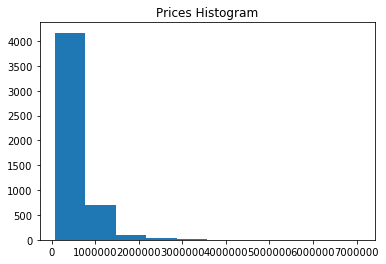

Mean: 557469.0
Standard Deviation: 375086.082666
Min: 78000
Max: 7062500


In [94]:
plt.title('Prices Histogram')
plt.hist(integratedData['price'])
plt.show()
print 'Mean: ' + str(round(integratedData['price'].mean()))
print 'Standard Deviation: ' + str(integratedData['price'].std())
print 'Min: ' + str(integratedData['price'].min())
print 'Max: ' + str(integratedData['price'].max())

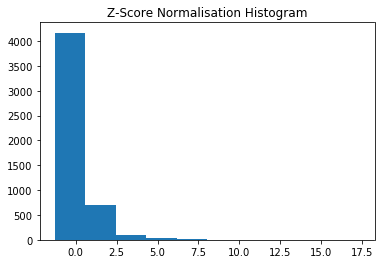

Mean: 0.0
Standard Deviation: 1.0
Min: -1.27841902453
Max: 17.3445021597


In [95]:
plt.title('Z-Score Normalisation Histogram')
plt.hist(priceZScoreNormalization)
plt.show()
print 'Mean: ' + str(round(priceZScoreNormalization.mean()))
print 'Standard Deviation: ' + str(priceZScoreNormalization.std())
print 'Min: ' + str(priceZScoreNormalization.min())
print 'Max: ' + str(priceZScoreNormalization.max())

**Z-Score Normalization Analysis**
- The mean and standard deviation is 0 and 1, as expected.
- There are negative values in `priceZScoreNormalization` but wasn't explicity shown in the histogram.
- The overall shape of the data distribution is **not** modified. The data still shows heavy positive skewness.

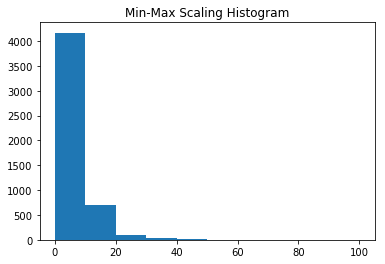

Mean: 6.86476096786
Standard Deviation: 5.36972685492
Min: 0.0
Max: 100.0


In [96]:
plt.title('Min-Max Scaling Histogram')
plt.hist(priceMinMaxScaling)
plt.show()
print 'Mean: ' + str(priceMinMaxScaling.mean())
print 'Standard Deviation: ' + str(priceMinMaxScaling.std())
print 'Min: ' + str(priceMinMaxScaling.min())
print 'Max: ' + str(priceMinMaxScaling.max())

**Min-Max Scaling Analysis**
- The mean (~7) and standard deviation (~5) is scaled and is around the 0 - 100 range.
- The min and max value is the arbitrary minimum and maximum prescribed in the equation.
- The overall shape of the data is **not** modified. The data still shows heavy positive skewness.
- The resulting histogram only has 6 bins, while the actual price has 8 bins, meaning the dataset was compressed.

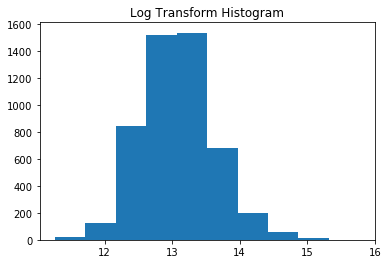

Mean: 13.0775311366
Standard Deviation: 0.534169922996
Min: 11.2644641057
Max: 15.7703096544


In [97]:
plt.title('Log Transform Histogram')
plt.hist(priceLogTransform)
plt.show()
print 'Mean: ' + str(priceLogTransform.mean())
print 'Standard Deviation: ' + str(priceLogTransform.std())
print 'Min: ' + str(priceLogTransform.min())
print 'Max: ' + str(priceLogTransform.max())

**Log Transform Analysis**
- The overall shape of the data has changed, from being positively skewed into a bell-shaped Normal Distribution.
- The effect of the outliers were minimised, and a lot of the dataset converges at the mean.
- The standard deviation was reduced significantly.

## 7.5 Using Data Transformation to Analyze Two Variables

As an example, I will also be performing Z-Score Normalization, Min-Max Scaling, and Log Transformation in another variable where price is highly correlated--'sqft_living' to see its effects when compared to 'price'.

In [98]:
y = integratedData['sqft_living']
numpyLiving = np.asarray(y)  

# Z-score normalization
livingZScoreNormalization = (numpyLiving - numpyLiving.mean()) / numpyLiving.std()

# MinMax scaling
min = 0
max = 100
livingMinMaxScaling = (numpyLiving - numpyLiving.min()) / (float(numpyLiving.max()) - numpyLiving.min())  * (max - min) + min 


# Log transformation
livingLogTransform = []
i = 0
for row in integratedData.iterrows():
    livingLogTransform.append(math.log(integratedData['sqft_living'][i]))
    i += 1

# For faster plotting, transform into a NumPy array
livingLogTransform = np.asarray(livingLogTransform)
livingLogTransform

array([ 7.57044325,  7.75790621,  7.7363071 , ...,  7.29979737,
        6.74523635,  6.68461173])

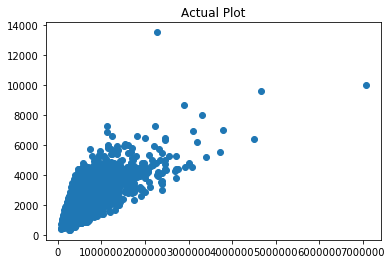

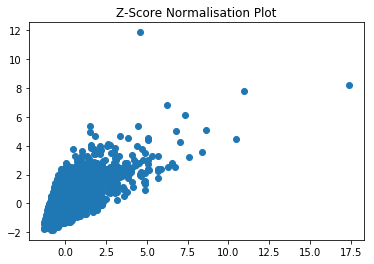

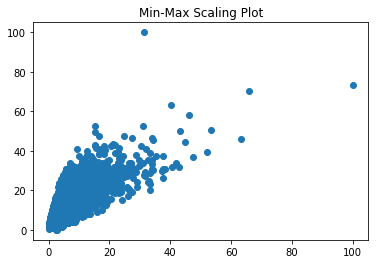

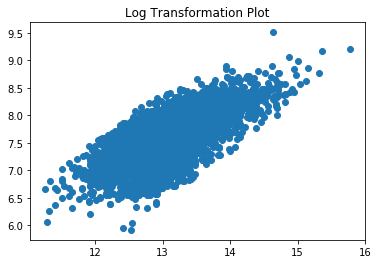

In [100]:
plt.title('Actual Plot')
plt.plot(integratedData['price'], integratedData['sqft_living'], 'o')
plt.show()
plt.title('Z-Score Normalisation Plot')
plt.plot(priceZScoreNormalization, livingZScoreNormalization, 'o')
plt.show()
plt.title('Min-Max Scaling Plot')
plt.plot(priceMinMaxScaling, livingMinMaxScaling, 'o')
plt.show()
plt.title('Log Transformation Plot')
plt.plot(priceLogTransform, livingLogTransform, 'o')
plt.show()

**Analysis**
- It is easier to read the plot when normalized or scaled because the overall shape is retained but the bin values are modified. In this case, it is easier to read decimal values and values between 0-100 than values with many zeroes.
- As it is earlier, one can see that the variance decreases when scaled, as the bins also decreased during scaling vs. normalizing.
- It is more inherent now that both variables are positively correlated when log transformed was applied into both variables because the effects of outliers were minimised.

# 8. Summary
This assessment illustrated ways to integrate data from different sources and reshape data through the use of different Python tools. Proper data integration is important due to the myriad of datasets in a variety of formats and sizes nowadays. This involves using appropriate tools to resolve conflicts arising from both schema-level and data-level integration. Appropriate data reshaping, meanwhile, is important to transform data into a format better suited for statistical analysis which may lead to better results.

The following tasks and techniques were performed in this assessment:

1. **Parsing an XML File and transforming it to a Dataframe.** Through the use of available libraries like **BeautifulSoup**, reading and analysing XML files are now easier to do in Python.
2. **Parsing a CSV File and transforming it to a Dataframe.** The all powerful **Pandas** library makes it possible to  transform a CSV File into a table and vice-versa through the `read_csv()` and `write_csv()` functions.
3. **Defining a Global Schema for data integration.** This is done by carefully analyzing the data and schema of the datasets and creating a mediated schema that reconciles their structure and whose values originate from both of these sources.
4. **Resolving schema-level and data-level conflicts in data from heterogenous sources.** Robust functions from the **Pandas** library like `to_numeric(), to_datetime()` for parsing and `replace() and str functions()` enable resolving schema-level and data-level conflicts more straightforward.
5. **Joining data from heterogenous sources.** This is easily done with **Pandas' `merge()`** function that allows SQL-like joins for two datasets.
6. **Reshaping data through Z-Score Normalization, Min-Max Scaling, and Log Transformation.** Mainly done through **Pandas and NumPy** structures, data reshaping is now easy to do in Python.
7. **Analyzing the shape and distribution of dataset after normalizing, scaling, and log transforming.** Plotting the resulting transformations and analysing them is possible through the use of matplotlib's `plot()` function. Z-Score Normalization and Min-Max Scaling transforms the dataset without changing its overall shape and distribution while Log Transformation reduces the effect of outliers in the data making it easier to see relationship between variables.

# 9. References

BitBoost Systems. (2011, Dec 12). United States Mailing Address Formats and Other International Mailing Information. Retrieved from Bitboost.com: http://www.bitboost.com/ref/international-address-formats/united_states/

Gattiker, U. (2013, Jan 15). How Data Are Normalized. Retrieved from HowTo.ComMetrics: http://howto.commetrics.com/methodology/statistics/normalization/

Lane, D. (2011, Aug 2). Log Transformations. Retrieved from Online Statistics Education: An Interactive Multimedia Course of Study: http://onlinestatbook.com/2/transformations/log.html

NumPy Developers. (2017, Jan 16). Quickstart Tutorial - Numpy and Scipy Documentation. Retrieved from Scipy.org: https://docs.scipy.org/doc/numpy-dev/user/quickstart.html

Pandas Developers. (2012, Jan 6). Merge, Join, and Concatenate. Retrieved from pandas 0.20.1 Documentation : https://pandas.pydata.org/pandas-docs/stable/merging.html

Pandas Developers. (2017, May 18). pandas.Series. Retrieved from pandas 0.20.1 Documentation: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html

Python Software Foundation. (2016, Jun 25). Numerical and Mathematical Modules. Retrieved from Python 2.7.13 Documentation: https://docs.python.org/2/library/math.html

Raschka, S. (2014, Jul 11). About Feature Scaling and Normalization. Retrieved from sebastianraschka: http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

Richardson, L. (2012, Feb 2). Beautiful Soup Documentation. Retrieved from Beautiful Soup 4.4.0 Documentation : https://www.crummy.com/software/BeautifulSoup/bs4/doc/

